In [111]:
%matplotlib notebook

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import geopandas as gp
from osgeo import gdal
import os

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 40601, 'height': 26567, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",47],PARAMETER["latitude_of_center",36],PARAMETER["longitude_of_center",85],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'), 'transform': Affine(90.0, 0.0, -1927410.319,
       0.0, -90.0, 1046489.151)}
Shape:  (1, 1334, 1334)
Max: 6398
Min: -32768


<IPython.core.display.Javascript object>


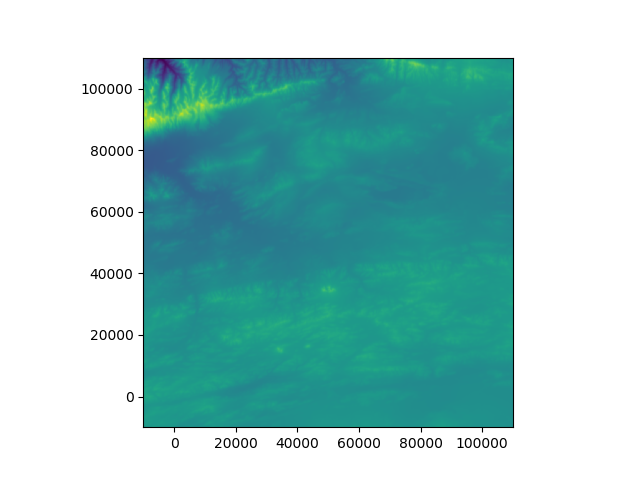

In [69]:
# CLIP RASTER

# Open input file
fp = r"/data/puma1/scratch/DEMs/srtm_test.tif"
raster = rasterio.open(fp, 'r')

# Output file path
out_tif = r"out1.tif"

# coordinate system as proj4 string
crs = "+proj=aea +lat_1=25 +lat_2=47 +lat_0=36 +lon_0=85 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

# create clip extent
#minX, maxX, minY, maxY = 400000, 500000, 0, 100000
minX, maxX, minY, maxY = 0, 100000, 0, 100000
size = (maxX-minX)*0.1
extent = [Polygon([(minX-size,minY-size), (minX-size,maxY+size), (maxX+size,maxY+size), (maxX+size,minY-size),  (minX-size,minY-size)])]

#help(mask)
out_img, out_transform = mask(dataset = raster, shapes=extent, crop=True)
out_meta = raster.meta.copy()
print(out_meta)
print('Shape: ', out_img.shape)
print('Max: %s' % out_img.max())
print('Min: %s' % out_img.min())

# update metadata with new dimensions
out_meta.update({"driver":   "GTiff",
                "height": out_img.shape[1], 
                "width": out_img.shape[2], 
                "transform": out_transform,
                "crs": crs})

# save clipped raster file
with rasterio.open(out_tif, 'w', **out_meta) as dest:
    dest.write(out_img)

raster.close()
    
# open clipped raster
clipped = rasterio.open(out_tif)

# plot
show(clipped, transform=clipped.transform, cmap='viridis')

In [112]:
fp = "/data/puma1/scratch/DEMs/srtm_test.tif"
out_tif = "/vsimem/tile_%s_%s_%s_%s.tif" % (minX, maxX, minY, maxY)
out_xyz = '/data/puma1/scratch/DEMs/tile_%s_%s_%s_%s.xyz' % (minX, maxX, minY, maxY)
ds = gdal.Open(fp)
size = (maxX-minX)*0.1
tile = gdal.Translate(out_tif, ds, projWin = [minX-size, maxY+size, maxX+size, minY-size])
del ds

gdal.Translate(out_xyz, tile, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
del tile

xy,values = [], []
#noData = clipped.nodatavals[0]
with open(out_xyz,'r') as f:
    f.readline() # skip first row
    for l in f:
        row = l.split()
        #if row[2]!=noData:
        xy.append([float(row[0]) , float(row[1])])
        values.append(float(row[2]))

# remove xyz  file
if os.path.exists(out_xyz):
    os.remove(out_xyz)
    
xy = np.asarray(xy)
values = np.asarray(values)

### TODO: DELETE THIS
# create a dataframe with random numbers
points = np.random.randint(low=minX, high=maxX, size=(100,2))
df = pd.DataFrame(points, columns = ['x', 'y'])
df['elev'] = 5000

# get point coordinates as numpy
coords = np.asarray([df['x'], df['y']])
coords = np.transpose(coords)

# interpolate
result=griddata(xy, values, coords, method='cubic')

# calculate difference
df['refElevation'] = result
df['refDifference'] = df['refElevation']-df['elev']
df



,x,y,elev,refElevation,refDifference
0,92575,79001,5000,4919.402866,-80.597134
1,14946,69175,5000,4722.583588,-277.416412
2,81046,35480,5000,5188.932711,188.932711
3,65989,28409,5000,5106.861388,106.861388
4,4139,36410,5000,4793.697718,-206.302282
5,95122,98028,5000,5032.157356,32.157356
6,49581,69503,5000,4859.331298,-140.668702
7,69089,77719,5000,4868.866298,-131.133702
8,14459,65407,5000,4570.974811,-429.025189
9,94645,21887,5000,5117.553687,117.553687


In [110]:
xyz.RasterCount
arr = xyz.ReadAsArray()
arr



array([[4100, 4103, 4116, ..., 5118, 5113, 5112],
       [4117, 4123, 4136, ..., 5138, 5133, 5132],
       [4136, 4144, 4158, ..., 5151, 5147, 5144],
       ...,
       [5088, 5086, 5084, ..., 4948, 4947, 4946],
       [5080, 5078, 5076, ..., 4950, 4949, 4948],
       [5072, 5070, 5068, ..., 4952, 4951, 4950]], dtype=int32)

In [71]:
# convert raster to XYZ files
filename = r"out3.tif"
inDs = gdal.Open(filename)
#print('out.xyz', inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
outDs = gdal.Translate('out.xyz', inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])

In [72]:
# read XYZ file

xy,values = [], []
x,y = [], []
noData = clipped.nodatavals[0]
with open('out.xyz','r') as f:
    f.readline()
    for l in f:
        row = l.split()
        #if row[2]!=noData:
        xy.append([float(row[0]) , float(row[1])])
        values.append(float(row[2]))
        
xy = np.asarray(xy)
values = np.asarray(values)

In [277]:
# no data values
#clipped.nodatavals[0]
#values[values==clipped.nodatavals[0]]=np.nan
#values[values==clipped.nodatavals[0]]=None
#print(type(values))


In [73]:
# create a dataframe with random numbers
points = np.random.randint(low=minX, high=maxX, size=(100,2))
df = pd.DataFrame(points, columns = ['x', 'y'])
df['elev'] = 5000

# get coordinates as numpy
coords = np.asarray([df['x'], df['y']])
coords = np.transpose(coords)
#coords

In [74]:
import time
#points = np.array([[1,1],[1,2],[2,2],[2,1]])
#v = np.array([1,3,5,2])
# xi=([5000,5000])

#xi=([[5000,5000], [4000,5000], [4000,3000], [6000,5000], [5000,6000], [5000,5000], [4000,5000], [4000,3000], [6000,5000], [5000,6000]])



start= time.time()
result=griddata(xy, values, coords, method='cubic')
print('Time: ',time.time()-start)



#result=griddata(points, v, ([1.2,1.3]), method='cubic')
#print("Value of interpolated function at",coords,"=",*result)
#4797.817222329357

Time:  28.90444827079773


In [75]:
# calculate elevation difference
df['refElevation'] = result
df['refDifference'] = df['refElevation']-df['elev']
df

,x,y,elev,refElevation,refDifference
0,88235,87187,5000,4874.256904,-125.743096
1,62159,68058,5000,4818.033846,-181.966154
2,60645,58981,5000,4805.943756,-194.056244
3,36606,57694,5000,4777.945014,-222.054986
4,77366,81252,5000,4916.305239,-83.694761
5,13868,32010,5000,5242.149029,242.149029
6,95575,6154,5000,4929.805485,-70.194515
7,71165,93723,5000,4922.280798,-77.719202
8,34558,25348,5000,5219.555822,219.555822
9,83316,51121,5000,5019.529174,19.529174


<IPython.core.display.Javascript object>


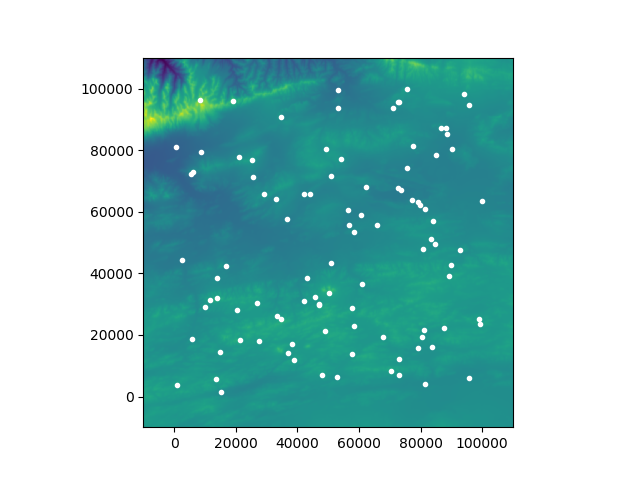

[4874.25690401 4818.03384625 4805.94375623 4777.94501413 4916.30523891
 5242.149029   4929.80548528 4922.28079829 5219.55582195 5019.52917403
 5073.7112308  4868.98914779 5057.63081634 4825.94605682 5149.18358717
 4817.11121355 5251.52910728 4901.73350654 4717.41078335 4963.4352372
 4745.08339123 5084.98718052 4889.77622481 5177.059467   5147.73661733
 4867.98682447 4883.80206865 5010.37108373 4926.73393542 4937.25804771
 4798.72415552 5114.05454128 4620.18831843 5040.66122825 5035.76295113
 5055.77742035 5110.91407121 4808.01849303 5067.89366799 5047.57601883
 5310.16911453 5015.49320928 4836.82815238 5601.16587331 5109.86269755
 4940.45262104 4717.20376454 5060.45697764 4849.96230765 5134.88827942
 5026.95728491 5126.69275013 5028.06311215 5182.48502035 5118.6703088
 5124.17126633 4606.87084891 4679.78766561 5119.24496329 5165.33067901
 4960.4225001  4816.10324808 5097.49058854 4959.4920459  4962.45611345
 5020.90360692 5192.94852322 4978.09475255 5058.16009995 4846.21550435
 5093.33

In [78]:
# plot result


fig,ax = plt.subplots()
show(cl, transform=clipped.transform, cmap='viridis', ax=ax)
t = np.transpose(points)
plt.scatter(t[0],t[1], marker='.', color='white')
#plt.scatter(xi[0], xi[1], color='white')
print(result)

In [12]:
# create extent geodataframe
extent = gp.GeoSeries([Polygon([(minX,minY), (minX,maxY/2), (maxX/2,maxY/2), (maxX/2,minY), (minX/2,minY)])])
dfExtent = gp.GeoDataFrame(geometry=extent)
dfExtent.crs = crs

In [18]:

geometry = [Point(xy) for xy in zip(df.x, df.y)]
geoDf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)


# 

leftJoin = gp.sjoin(geoDf, dfExtent, how='left', op='within')

#leftJoin['index_right'] = leftJoin['index_right'].map({0: 1})
#leftJoin.fillna(0, inplace=True)
#leftJoin.rename(columns={'index_right':'debris'}, inplace=True)
leftJoin['debris'] = (leftJoin['index_right'] >= 0).astype(int)
leftJoin.drop('index_right', axis=1, inplace=True)

leftJoin.groupby('debris').count()
leftJoin.loc[(leftJoin.debris == 1), 'x'].count()


20

In [19]:
leftJoin

,x,y,elev,refElevation,refDifference,geometry,debris
0,83610,15042,5000,4979.108652,-20.891348,POINT (83610 15042),0
1,94864,18021,5000,5113.672992,113.672992,POINT (94864 18021),0
2,70656,90532,5000,4869.487475,-130.512525,POINT (70656 90532),0
3,34256,62688,5000,4921.866422,-78.133578,POINT (34256 62688),0
4,3955,67393,5000,4472.314336,-527.685664,POINT (3955 67393),0
5,9403,85377,5000,4637.173596,-362.826404,POINT (9403 85377),0
6,52202,75874,5000,5024.070275,24.070275,POINT (52202 75874),0
7,95311,4061,5000,4932.132719,-67.867281,POINT (95311 4061),0
8,22473,15119,5000,5144.401459,144.401459,POINT (22473 15119),1
9,49594,84824,5000,5056.153140,56.153140,POINT (49594 84824),0


<IPython.core.display.Javascript object>


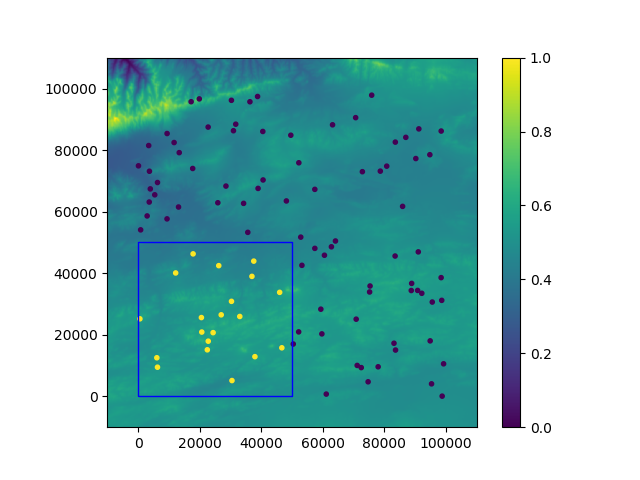

[4979.10865199 5113.67299224 4869.48747482 4921.8664219  4472.31433586
 4637.17359634 5024.07027506 4932.13271862 5144.40145861 5056.15314014
 4875.1091523  5115.97453314 5150.69889388 5081.04231961 4821.4409742
 4840.70308417 4858.17706713 4847.02067396 4663.06432549 4644.58822223
 5107.58084301 4791.93952023 5052.0447074  4818.75405742 4899.46513822
 4609.88204271 4951.50553105 4863.79976917 4410.0904326  4476.24100353
 4592.6459673  4683.16879548 4959.49213635 4596.90654973 4498.08954668
 5124.44462226 4870.13419211 5147.70702991 5124.35445382 5089.26426614
 5066.3759023  5171.4778997  4955.05897179 5121.47807004 4870.77596676
 4833.58085872 5226.86604773 4854.17259349 5021.19322236 4847.08423833
 5127.67966599 4793.80683134 5097.49839822 5063.13242034 4938.72385825
 4995.737428   5140.32664461 4871.15450394 5093.50456583 5161.69529805
 4786.15506501 4866.91961861 4770.53818144 5067.93982133 4796.63548014
 5173.15975894 4908.37356065 4905.23289945 4911.73744036 5079.19725429
 4795.1

In [14]:
fig,ax = plt.subplots()
show(clipped, transform=clipped.transform, cmap='viridis', ax=ax)
leftJoin.plot(column='debris', legend=True, marker='.', ax=ax)
dfExtent.plot(facecolor='None', edgecolor='blue', ax=ax)

print(result)